# Assignment 3

# Part I: Segmentation

## Problem 1
### Show algebraic equivalence between two non-parametric formulations for K-means (objectives $E(S)$ at the bottom of slide 58, Topic 9):
### $$  \sum_{k=1}^K \frac{\sum_{pq\in S^k}\|f_p-f_q\|^2}{2\;|S^k|} \;\;=\;\; const - \sum_{k=1}^K \frac{\sum_{pq\in S^k} \langle f_p,f_q\rangle}{|S^k|}$$

Solution:

## Problem 2 (a simple finite-dimensional version of Mercer theorem)
### Let $A$ be an $n\times n$ positive semi-definite matrix defining pairwise affinities between $n$ ponts. Find a closed expression for $n$ vectors $\phi_i$  (a so-called "Euclidean embedding") such that their Euclidean dot products agree with the given affinites, i.e. $\langle \phi_i,\phi_j\rangle = A_{ij}$ for all $1\leq i,j\leq n$. You can assume known eigen-decomposition $A=Q\Lambda Q^T$ where $Λ=diag(λ_1,…,λ_n)$ is a diagonal matrix of (non-negative!) eigen-values and $Q$ is an orthogonal $n\times n$ matrix whose columns $Q_i$ are unit eigen-vectors of $A$.

Solution: Suppose each for the vectors $\phi_i$ is of length $n$. Then since there are $n$ such vectors, we have $n^2$ variables (the $n$ components of each vector). We can create $n(n+1)/2$ formulas (since dot product is symmetric) for the components of these $\phi_i$ vectors:
$$\langle \phi_1,\phi_1\rangle = A_{11}, \langle \phi_1,\phi_2\rangle = A_{12}, \dots \langle \phi_1,\phi_n\rangle = A_{1n}$$

## Problem 3 (approximate low-dimenstional Euclidean embedding)
### Assume that $\tilde{A}$ is a low-rank approximation of matrix $A$ in problem 2 of given rank $m<n$. That is, $\tilde{A} = Q\Lambda_m Q^T$ where $\Lambda_m=diag(\lambda_1,\dots,\lambda_m,0,\dots,0)$ is a diagonal matrix of the largest $m$ eigen values of $A$ (a la Eckart–Young–Mirsky theorem, Topic 8). Using your solution for problem 2, specify a formula for "Euclidean embedding" $\{\tilde{\phi}_i\}$ such that $\langle \tilde{\phi}_i,\tilde{\phi}_j\rangle = \tilde{A}_{ij}$ and show that  $\tilde{\phi}_i \in {\cal R}^m$.
#### Comment: basic K-means (Lloyd's algorithm) over such points $\{\tilde{\phi}_i\}$ can be used as an approximate algorithm for kernel clusterng (e.g. for average association criteria). This approach is an example of "spectral clustering", which uses eigen decomposition of the affinity matrix $A$.

Solution: 

## Problem 4 (K-means). 
### Subproblem 4.1 
### Implement K-means algorithm for clustering pixel features. Most of the work is already done for you, but you do get a chance to play with numpy and to evaluate empirical properties of K-means.
#### The provided code below only computes random pixel segments. You need to write code producing correct clusters and correct "means". To achive this you only need to complete implementation of functions $compute\_means$ and $compute\_labels$ inside "MyKmenasApp" corresponding to the two iterative steps in Lloyd's algorithm (as in "compute_k_means_clusters"). 
#### Your implementation of the main two steps of K-means algorithm should use RGBXY features. Relative contribution of "squared errors" from XY features must be set by parameter "weightXY" (or self.w inside MyKmeansApp), so that the squared error between RGBXY feture $F_p=[R_p,G_p,B_p,X_p,Y_p]$ at any pixel $p$ and any given cluster mean $m=[R_m,G_m,B_m,X_m,Y_m]$ is 
#### $$||F_p - m||^2 = (R_p - R_m)^2 + (G_p - G_m)^2 + (B_p - B_m)^2 + w \cdot (X_p-X_m)^2 + w \cdot (Y_p-Y_m)^2.$$
#### Fully implemented "KmeansPresenter" visulaizes the segmentation results (cluster labels mask) where each cluster is highlighted either by some  random color (press r-key) or by the "mean" segment color (press m-key). All keys that "KmeansPresenter" responds to are as follows: 

1. press 'i'-key for each (i)teration of K-means 
2. press 'c'-key to run K-means to (c)onvergence (when energy improvement is less than given threshold)
3. press 'v'-key to run K-means to convergence with (v)isualization of each iteration
4. press 'r'-key to start over from (r)andom means
5. press 's'-key to change to a random (s)olid color-palette for displaying clusters
6. press 't'-key to change to a random (t)ransparent palette for displaying clusters
7. press 'm'-key to change to the (m)ean-color palette for displaying clusters

In [1]:
%matplotlib notebook
# loading standard modules
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from skimage.color import rgb2grey

# loading custom module (requires file asg1.py in the same directory as the notebook file)
from asg1_error_handling import Figure, KmeansPresenter

In [2]:
class MyKmeansApp:

    def __init__(self, img, num_clusters=2, weightXY=1.0):
        self.k = num_clusters
        self.w = weightXY
        self.iteration = 0   # iteration counter
        self.energy = np.infty  # energy - "sum of squared errors" (SSE)

        num_rows = self.num_rows = img.shape[0]
        num_cols = self.num_cols = img.shape[1]

        self.im = img
        
        self.means = np.zeros((self.k,5),'d') # creates a zero-valued (double) matrix of size Kx5
        self.init_means()
      
        self.no_label = num_clusters  # special label value indicating pixels not in any cluster (e.g. not yet) 

        # mask "labels" where pixels of each "region" will have a unique index-label (like 0,1,2,3,..,K-1)
        # the default mask value is "no-label" (K) implying pixels that do not belong to any region (yet)
        self.labels = np.full((num_rows, num_cols), fill_value=self.no_label, dtype=np.int)
        
        self.fig = Figure()
        self.pres = KmeansPresenter(img, self)
        self.pres.connect_figure(self.fig)
       
    def run(self):
        self.fig.show()
        
    def init_means(self):      
        self.iteration = 0           # resets iteration counter 
        self.energy = np.infty       # and the energy

        poolX = range(self.num_cols)
        poolY = range(self.num_rows)
        
        # generate K random pixels (Kx2 array with X,Y coordinates in each row)
        random_pixels = np.array([np.random.choice(poolX,self.k),np.random.choice(poolY,self.k)]).T
        
        for label in range(self.k):
            self.means[label,:3] = self.im[random_pixels[label,1],random_pixels[label,0],:3]
            self.means[label,3] = random_pixels[label,0]
            self.means[label,4] = random_pixels[label,1]
    
    # This function compute average values for R, G, B, X, Y channel (feature component) at pixels in each cluster
    # represented by labels in given mask "self.labels" storing indeces in range [0,K). The averages should be
    # saved in (Kx5) matrix "self.means". The return value should be the number of non-empty clusters. 
    def compute_means(self):
        labels = self.labels
        non_empty_clusters = 0
        
        # Your code below should compute average values for R,G,B,X,Y features in each segment 
        # and save them in (Kx5) matrix "self.means". For empty clusters set the corresponding mean values 
        # to infinity (np.infty). Report the correct number of non-empty clusters by the return value.
    
        return non_empty_clusters
            
    # The segmentation mask is used by KmeanPresenter to paint segments in distinct colors
    # NOTE: valid region labels are in [0,K), but the color map in KmeansPresenter
    #       accepts labels in range [0,K] where pixels with no_label=K are not painted/colored.
    def get_region_mask(self):  
        return self.labels  
    
    # This function computes optimal (cluster) index/label in range 0,1,...,K-1 for pixel x,y based on 
    # given current cluster means (self.means). The functions should save these labels in "self.labels".
    # The return value should be the corresponding optimal SSE.
    def compute_labels(self):
        shape = (self.num_rows,self.num_cols)
        opt_labels = np.full(shape, fill_value=self.no_label, dtype=np.int) # HINT: you can use this array to store and update
                                                                            # currently the best label for each pixel.
        
        min_dist = np.full(shape, fill_value=np.inf)  # HINT: you can use this array to store and update 
                                                      # the (squared) distance from each pixel to its current "opt_label".
                                                      # use 'self.w' as a relative weight of sq. errors for X and Y components
        
        # Replace the code below by your code that computes "opt_labels" array of labels in range [0,K) where 
        # each pixel's label is an index 'i' such that self.mean[i] is the closest to R,G,B,X,Y values of this pixel.
        # Your code should also update min_dist so that it contains the optmail squared errors  
        opt_labels = np.random.choice(range(self.k),shape)
        min_dist = np.random.choice(range(100),shape)
 
        # update the labels based on opt_labels computed above
        self.labels = opt_labels
        
        # returns the optimal SSE (corresponding to optimal clusters/labels for given means)
        return min_dist.sum()
            
    # The function below is called by "on_key_down" in KmeansPresenter".
    # It's goal is to run an iteration of K-means procedure 
    # updating the means and the (segment) labels 
    def compute_k_means_clusters(self):  
        self.iteration += 1  

        # the main two steps of K-means algorithm
        energy = self.compute_labels()
        num_clusters = self.compute_means()

        # computing improvement and printing some information
        num_pixels = self.num_rows*self.num_cols
        improve_per_pixel = (self.energy - energy)/num_pixels
        energy_per_pixel = energy/num_pixels
        self.energy = energy
        
        self.fig.ax.text(0, -8,   # text location  
                         'iteration = {:_>2d},  clusters = {:_>2d},  SSE/p = {:_>7.1f},   improve/p = {:_>7.3f}    '.format(
                          self.iteration,       num_clusters,        energy_per_pixel,    improve_per_pixel),
                          bbox={'facecolor':'white', 'edgecolor':'none'})
       
        return improve_per_pixel

### Subproblem 4.2
### Use K-means to generate 3-4 representative results (you can use your own images) with color quantization and superpixels. Experiment with different values of parameter K (in the range 2-80).  Compare representative values of optimal SSE for smaller and larger K and explain the observed differences. Add more cells (code and/or text) as necessary.

<IPython.core.display.Javascript object>


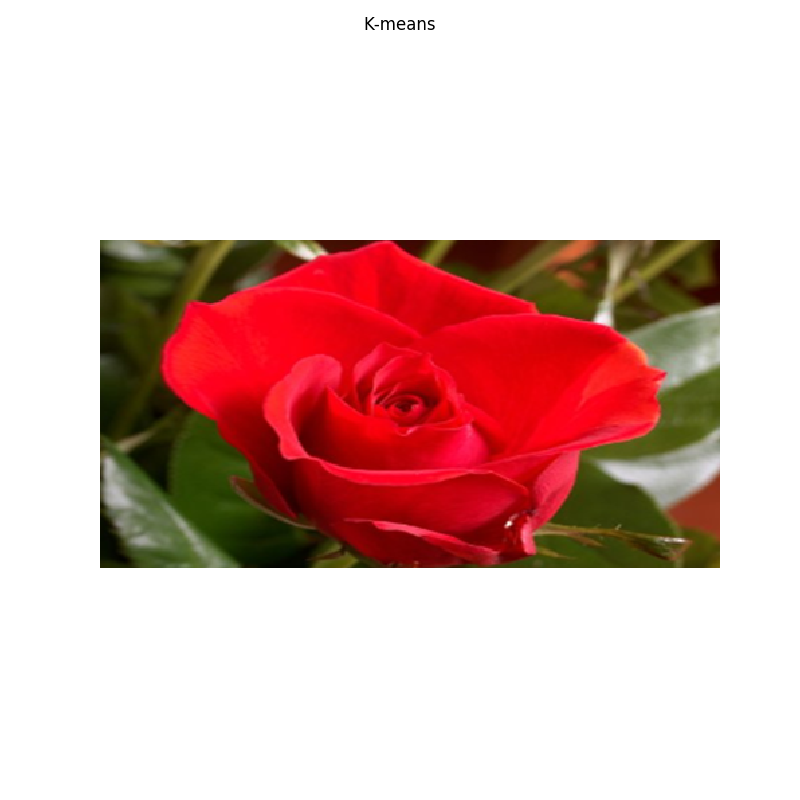

In [3]:
img = plt.imread('images/rose.bmp')
app = MyKmeansApp(img, num_clusters=80, weightXY=2.0)
app.run()

### Subprobelm 4.3
### Evaluate sensitivity of K-means to local minima  (you can use your own images). Show 2-3 different solutions for different random initial means and display the corresponding values of the K-means energy. Add more cells (code and/or text) as necessary.

<IPython.core.display.Javascript object>


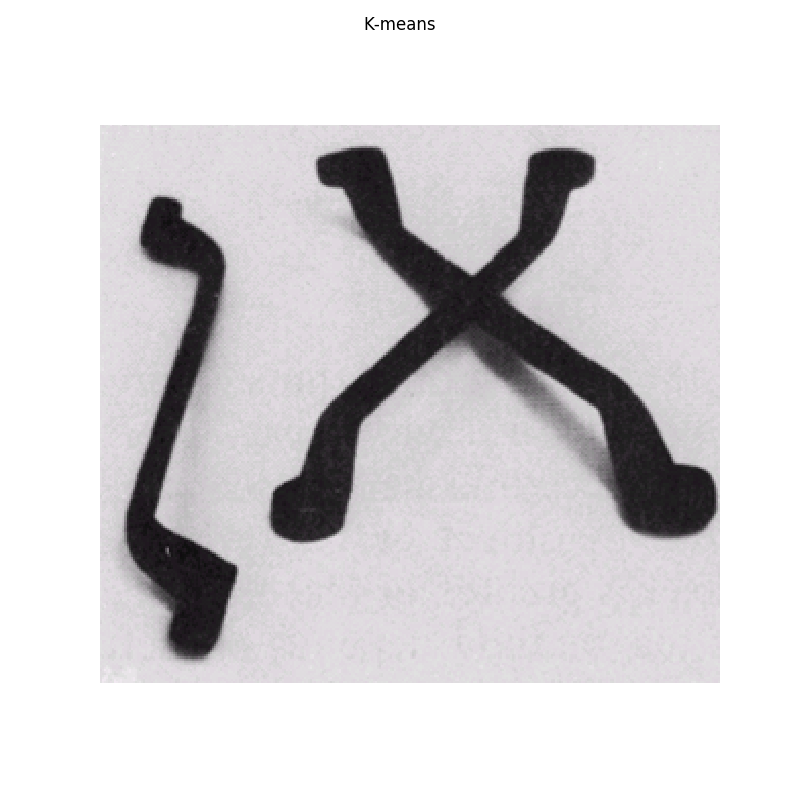

In [4]:
img = plt.imread('images/tools.bmp')
app = MyKmeansApp(img, num_clusters=3, weightXY=0.0)
app.run()